In [1]:
!pip3 install pyLDAvis==3.2.2
!pip3 install sentence_transformers
!pip3 install bertopic
!pip3 install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=ae47524263bced092577c438f6572e2b899bbf6fe89a0c94299a33e17ce9625a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Obtaining dependency information for cython<3,>=0.27 from https://files.pyth

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim
import langid
import random
import sklearn

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from datasets import Dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from hdbscan import HDBSCAN
from bertopic import BERTopic
from IPython.display import Image

torch.manual_seed(15)
torch.backends.cuda.deterministic = True

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# **Data Understanding**


# Load and Preprocess Data


In [4]:
# Download data from https://drive.google.com/drive/folders/1jwh225T0DIEN4A1wMZ8-dVJX-2Tsovqf?usp=sharing
df = pd.read_csv("/kaggle/input/kyivchannels/KyivChannels_Dataset_v01.csv", converters={"Date": pd.to_datetime})

In [5]:
df.head()

channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang  
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru

In [6]:
df.shape

(31182, 4)

In [7]:
df.isna().sum(axis=0)

channelname    0
Date           0
content        0
lang           0
dtype: int64

In [8]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

## Let's take first and second channels, because they consist of the most posts.

In [9]:
df_novynylive = df.loc[df['channelname'] == 'novynylive']
df_lossolomas_kyiv = df.loc[df['channelname'] == 'lossolomas_kyiv'] 

In [10]:
df_novynylive.head()

channelname                Date  \
159  novynylive 2023-08-01 07:20:15   
174  novynylive 2023-08-01 05:03:01   
175  novynylive 2023-08-01 06:39:05   
177  novynylive 2023-08-01 06:29:01   
179  novynylive 2023-08-01 11:40:15   

                                               content lang  
159  На одній з вулиць Одеси повзає величезна змія\...   uk  
174  ⚡️ Суд покарав пасажира Range Rover за пісні Л...   uk  
175  Кадри зсередини профучилища у Салтівському рай...   uk  
177  Це був не прорив «Зернового коридору»: Братчук...   uk  
179  Наслідки нічної атаки РФ безпітлотниками по Са...   uk

In [11]:
# def detect_language(text):
#     lang, _ = langid.classify(text)
#     return lang

# df["lang"] = df["content"].apply(detect_language)
df_novynylive["lang"].value_counts()

lang
uk    3580
ru       7
bg       2
sr       1
Name: count, dtype: int64

In [12]:
df_lossolomas_kyiv.head()

channelname                Date  \
228  lossolomas_kyiv 2023-08-01 20:59:12   
230  lossolomas_kyiv 2023-08-01 16:14:28   
234  lossolomas_kyiv 2023-08-01 12:10:56   
235  lossolomas_kyiv 2023-08-01 12:05:13   
236  lossolomas_kyiv 2023-08-01 12:52:14   

                                               content lang  
228                                               ОГО!   ru  
230                        Загроза «мопєдів» з Півдня.   uk  
234  В рамках сьогоднішнього дня - це справжня ядер...   uk  
235  Боже, як ці великі і медійні фонди тримаються,...   uk  
236  Короче, приват24 - привіт\nВони обмежують нас ...   uk

In [13]:
# def detect_language(text):
#     lang, _ = langid.classify(text)
#     return lang

# df["lang"] = df["content"].apply(detect_language)
df_lossolomas_kyiv["lang"].value_counts()

lang
uk    2535
ru     163
en     124
ja      51
sr      27
be      23
bg      17
zh      16
kk      16
vi       8
mn       4
pl       3
mt       2
bn       2
ky       2
rw       2
fr       1
bs       1
hr       1
ka       1
zu       1
hu       1
mk       1
da       1
mr       1
he       1
qu       1
sv       1
sl       1
fi       1
Name: count, dtype: int64

# Date dependency

In [14]:
df_novynylive["Date_day"] = df_novynylive["Date"].apply(lambda x: x.date())
df_lossolomas_kyiv["Date_day"] = df_lossolomas_kyiv["Date"].apply(lambda x: x.date())

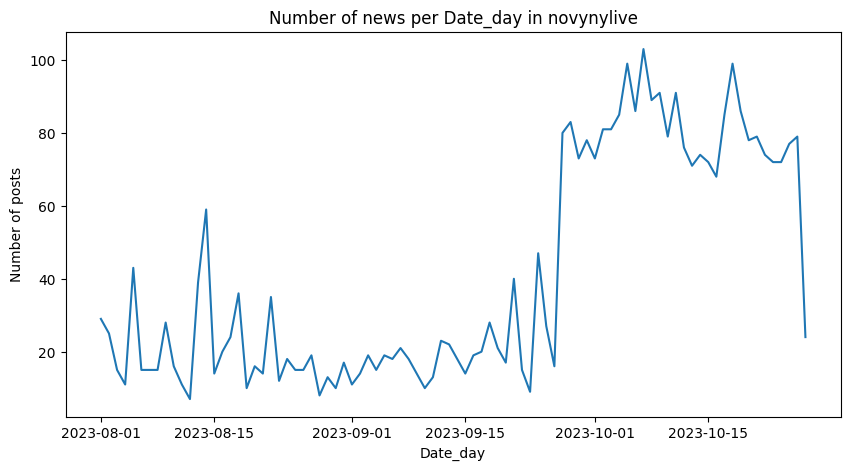

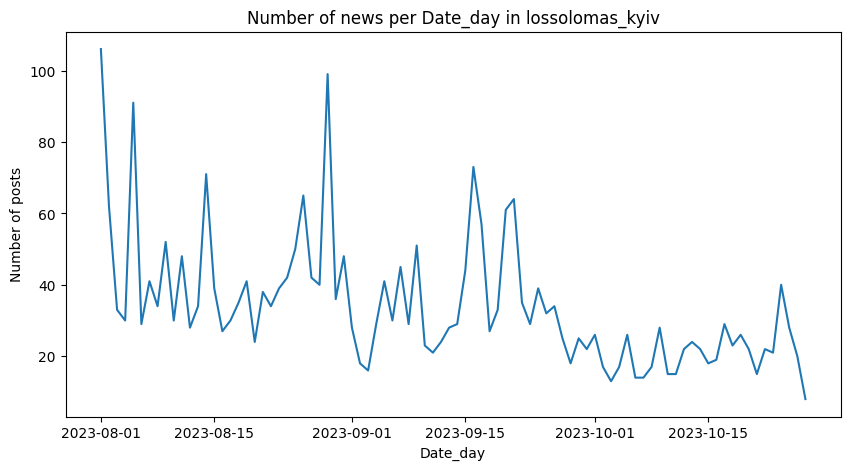

In [15]:
for df, df_name in zip([df_novynylive, df_lossolomas_kyiv], ['novynylive', 'lossolomas_kyiv']):
    
    plt.figure(figsize=(10,5))
    plt.title(f"Number of news per Date_day in {df_name}")
    df.groupby("Date_day")["content"].count().plot()
    plt.xlabel("Date_day")
    plt.ylabel("Number of posts")
    plt.show()

# **Text Visualisation**

In [16]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Let's look at few samples to consider what preprocessing steps may lead us to better results 

##  novynylive

In [17]:
for idx in [0, 35, 100, 500]:
    print(f'index={idx}')
    print(f'sample :\n {df_novynylive["content"].iloc[idx]}')
    print('____________________________________________')

index=0
sample :
 На одній з вулиць Одеси повзає величезна змія

Звідки вона втекла — невідомо. Втім, вона вже встигла стати зіркою мережі. 

🇺🇦 Новини.LIVE Одеса
____________________________________________
index=35
sample :
 Одесити, які постраждали внаслідок атак РФ по місту в липні, виписані з лікарні

Наразі вони знаходяться на амбулаторному лікуванні. Також їм виплачується матеріальна допомога — від 50 до 100 тисяч гривень.

За даними Одеської міськради, в лікарні ще продовжує перебувати дитина з Тернополя, яка постраждала 23 липня. Її стан, за словами лікарів, вже стабільний.

🇺🇦 Новини.LIVE Одеса
____________________________________________
index=100
sample :
 У КМВА теж повідомляють про ракетну небезпеку та закликають прямувати в укриття

🇺🇦📞 Ми у Viber
____________________________________________
index=500
sample :
 Заборона виїзду чоловікам за кордон після війни: депутат пояснив

Якщо Україна хоче бути частиною ЄС, НАТО та демократичного суспільства, то забороняти виїзд чоло

## lossolomas_kyiv

In [18]:
for idx in [0, 35, 100, 500]:
    print(f'index={idx}')
    print(f'sample :\n {df_lossolomas_kyiv["content"].iloc[idx]}')
    print('____________________________________________')

index=0
sample :
 ОГО!
____________________________________________
index=35
sample :
 Нагадуємо , для чого все це сьогодні у нас несеться🔥🔥🔥
____________________________________________
index=100
sample :
 Сподіваємось КМВА вистачить мізків не викладати фото.
____________________________________________
index=500
sample :
 Це вже майже фінішна пряма🔥🔥🔥
І саме ВИ - сила всього цього!

Лишилось всього 85.000 !

Давайте свої ранкові 10 гривень долучимо до підтримки війська! 
Зґуртовано закриємо запит швидше!!


Нас чекає ще підготовка та логістика , а це час - час в цьому випадку грає проти нас.

3 Окрема Штурмова Бригада - 2 ШТУРМОВИЙ батальйон потребує авто!
Батальйон Свобода , мінометний підрозділ - потребує авто!!

Напрямок - Бахмут.
Ми всі читаємо новини і бачимо результати, тому активно та щоденно підтримуємо бойові підрозділи!!
Переможемо🫡

ЗБІР НА 2 АВТО ДЛЯ ФРОНТУ

🔗Посилання на банку
https://send.monobank.ua/jar/3WqZGemxQw

💳Номер картки банки
5375 4112 0798 1148

4323357011002

## We can notice a topic through these messeges. For instance, in novynylive we can amdit that in messeges we looked at Odesa is mentioned and in lossolomas_kyiv we see that in our examples  people raising money to support the military.

## Talking about preprocessing we probably should get rid of emoji, punctuation, special symbols and, considering from life experience, remove references, extra whitespaces etc. 

# Preprocessing

In [19]:
def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def preprocess_text(text, del_phrases=None):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    for symb in ["!", ",", ":", ";", "?"]:
            text = re.sub(rf"\{symb}\.", symb, text)
            
    # Remove special symbols and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove links
    text = re.sub(r"http\S+", "", text)
    
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    
    # Colapse dots
    text = collapse_dots(text)
    
    text = text.strip()
    

    if del_phrases is not None:
        for phrase in del_phrases:
            text = re.sub(rf'\b{re.escape(phrase)}\b', '', text)
    

    return text

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
/tmp/ipykernel_20/3058668450.py:3: DeprecationWarning: invalid escape sequence '\.'
  input = re.sub("\.+", ".", input)


In [20]:
df_lossolomas_kyiv["content_processed"] = df["content"].apply(preprocess_text)
for idx in [0, 35, 100, 500]:
    print(f'index={idx}')
    print(f'sample :\n {df_lossolomas_kyiv["content"].iloc[idx]}')
    print(f'preprocessed sample :\n {df_lossolomas_kyiv["content_processed"].iloc[idx]}')
    print('____________________________________________')

index=0
sample :
 ОГО!
preprocessed sample :
 ОГО
____________________________________________
index=35
sample :
 Нагадуємо , для чого все це сьогодні у нас несеться🔥🔥🔥
preprocessed sample :
 Нагадуємо  для чого все це сьогодні у нас несеться
____________________________________________
index=100
sample :
 Сподіваємось КМВА вистачить мізків не викладати фото.
preprocessed sample :
 Сподіваємось КМВА вистачить мізків не викладати фото
____________________________________________
index=500
sample :
 Це вже майже фінішна пряма🔥🔥🔥
І саме ВИ - сила всього цього!

Лишилось всього 85.000 !

Давайте свої ранкові 10 гривень долучимо до підтримки війська! 
Зґуртовано закриємо запит швидше!!


Нас чекає ще підготовка та логістика , а це час - час в цьому випадку грає проти нас.

3 Окрема Штурмова Бригада - 2 ШТУРМОВИЙ батальйон потребує авто!
Батальйон Свобода , мінометний підрозділ - потребує авто!!

Напрямок - Бахмут.
Ми всі читаємо новини і бачимо результати, тому активно та щоденно підтримуєм

In [21]:
df_novynylive["content_processed"] = df_novynylive["content"].apply(preprocess_text)
for idx in [0, 35, 100, 500]:
    print(f'index={idx}')
    print(f'sample :\n {df_novynylive["content"].iloc[idx]}')
    print(f'preprocessed sample :\n {df_novynylive["content_processed"].iloc[idx]}')
    print('____________________________________________')

index=0
sample :
 На одній з вулиць Одеси повзає величезна змія

Звідки вона втекла — невідомо. Втім, вона вже встигла стати зіркою мережі. 

🇺🇦 Новини.LIVE Одеса
preprocessed sample :
 На одній з вулиць Одеси повзає величезна змія Звідки вона втекла  невідомо Втім вона вже встигла стати зіркою мережі  НовиниLIVE Одеса
____________________________________________
index=35
sample :
 Одесити, які постраждали внаслідок атак РФ по місту в липні, виписані з лікарні

Наразі вони знаходяться на амбулаторному лікуванні. Також їм виплачується матеріальна допомога — від 50 до 100 тисяч гривень.

За даними Одеської міськради, в лікарні ще продовжує перебувати дитина з Тернополя, яка постраждала 23 липня. Її стан, за словами лікарів, вже стабільний.

🇺🇦 Новини.LIVE Одеса
preprocessed sample :
 Одесити які постраждали внаслідок атак РФ по місту в липні виписані з лікарні Наразі вони знаходяться на амбулаторному лікуванні Також їм виплачується матеріальна допомога  від 50 до 100 тисяч гривень За дан

# Stopwords

In [22]:
def read_txt_to_list(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# Taken from https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt 
ua_stopwords = read_txt_to_list("/kaggle/input/stopwords/stopwords_ua.txt.txt")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


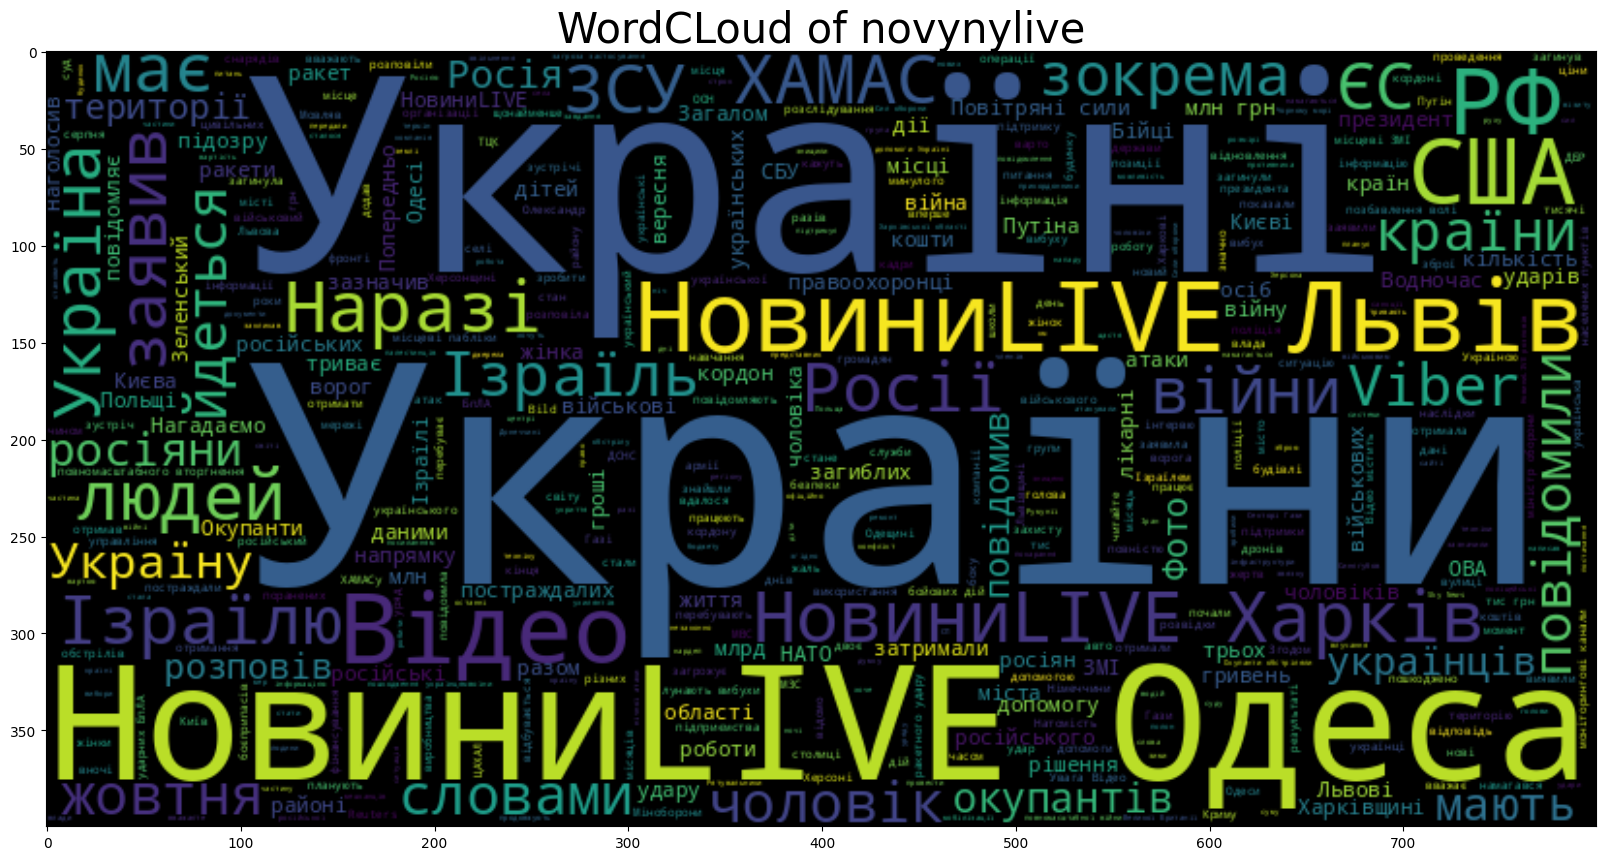

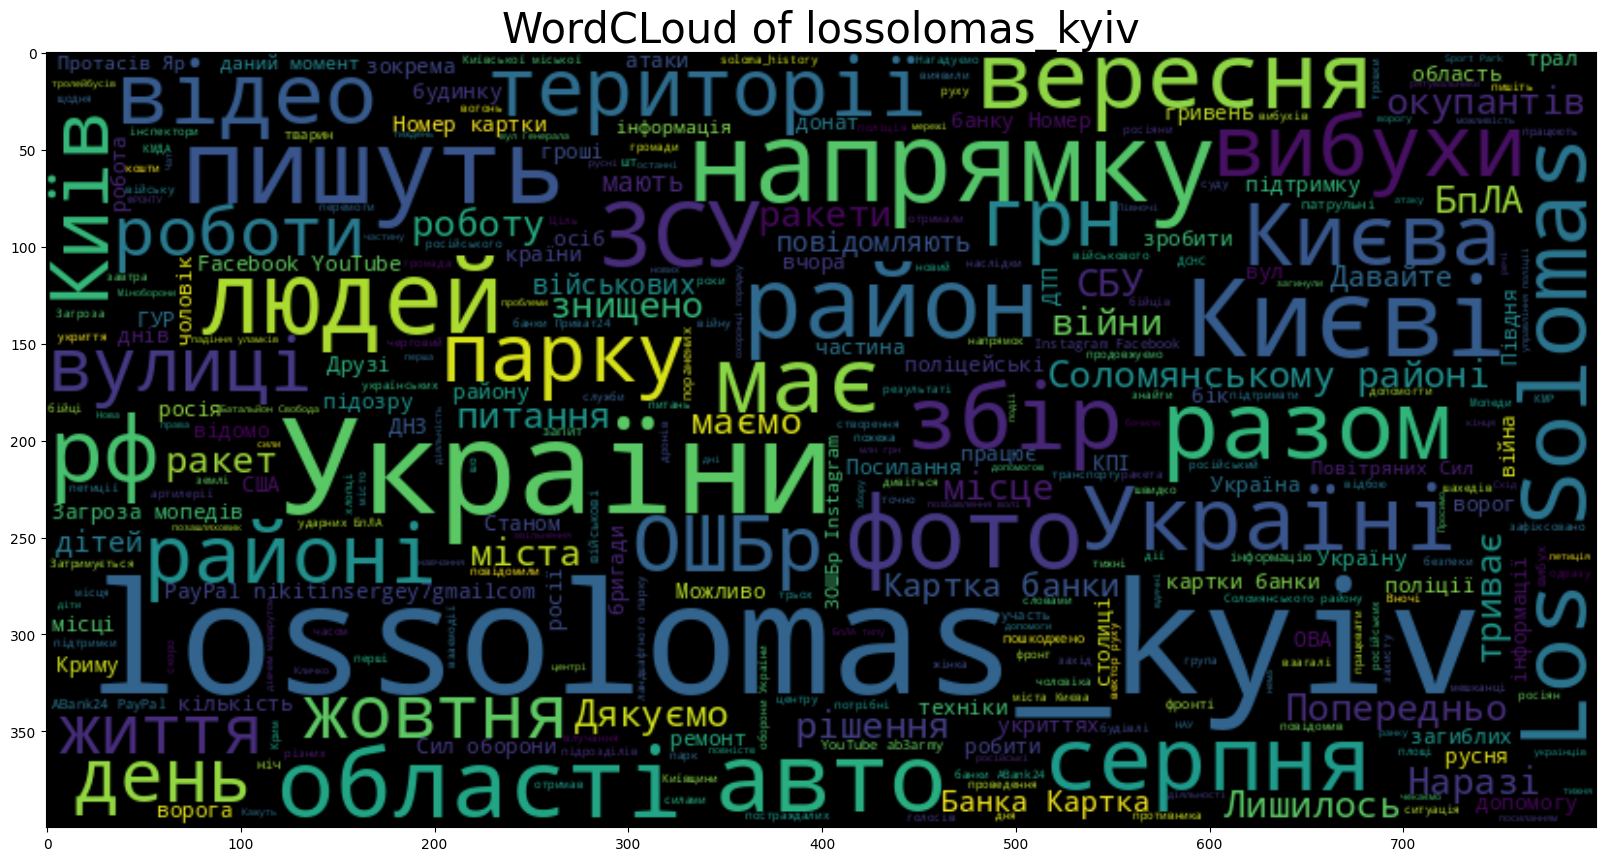

In [23]:
for df, df_name in zip([df_novynylive, df_lossolomas_kyiv], ['novynylive', 'lossolomas_kyiv']):
    plt.figure(figsize = (20,20)) 
    wc = WordCloud(
        max_words = 500, 
        width = 800, 
        height = 400, 
        stopwords = (ru_stopwords + ua_stopwords)).generate(" ".join(df["content_processed"]))
    plt.title(f"WordCLoud of {df_name}", fontsize=30)
    plt.imshow(wc, interpolation = 'bilinear')

## Now I'm going to extend stopwords list to reduce noise while implementing topic modeling. 

In [24]:
for df, del_phrases in zip([df_novynylive, df_lossolomas_kyiv], [["НовиниLIVE","НовиниLIVE Львів", "НовиниLIVE Одеса", "НовиниLIVE Харків"], ["lossolomas_kyiv", 'Los Solomas']]):
    df["content_processed"] = df["content"].apply(lambda row: preprocess_text(row, del_phrases))

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


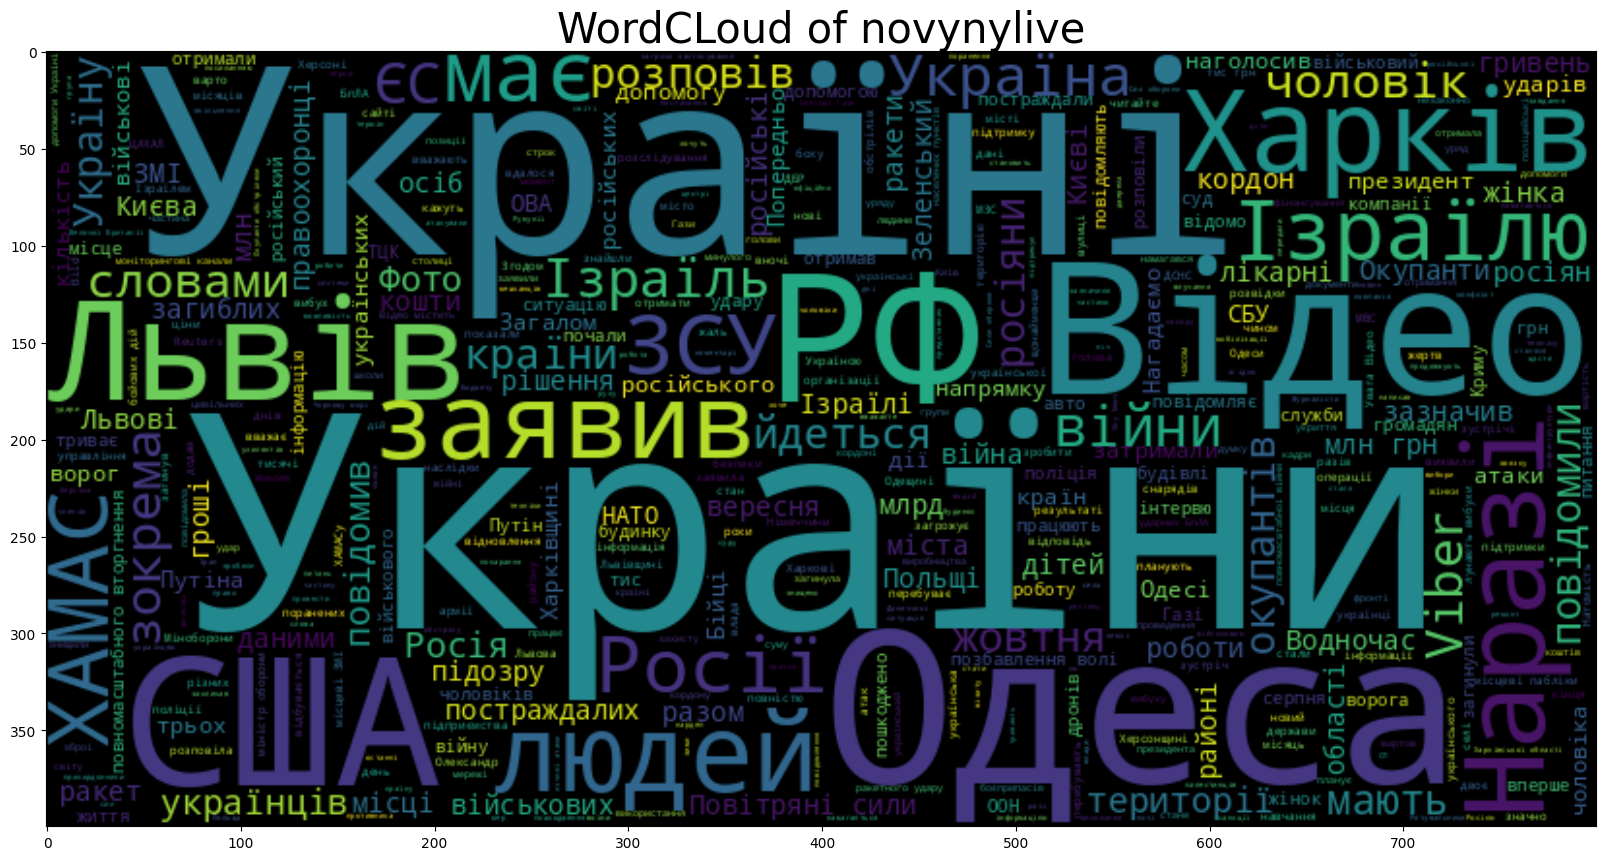

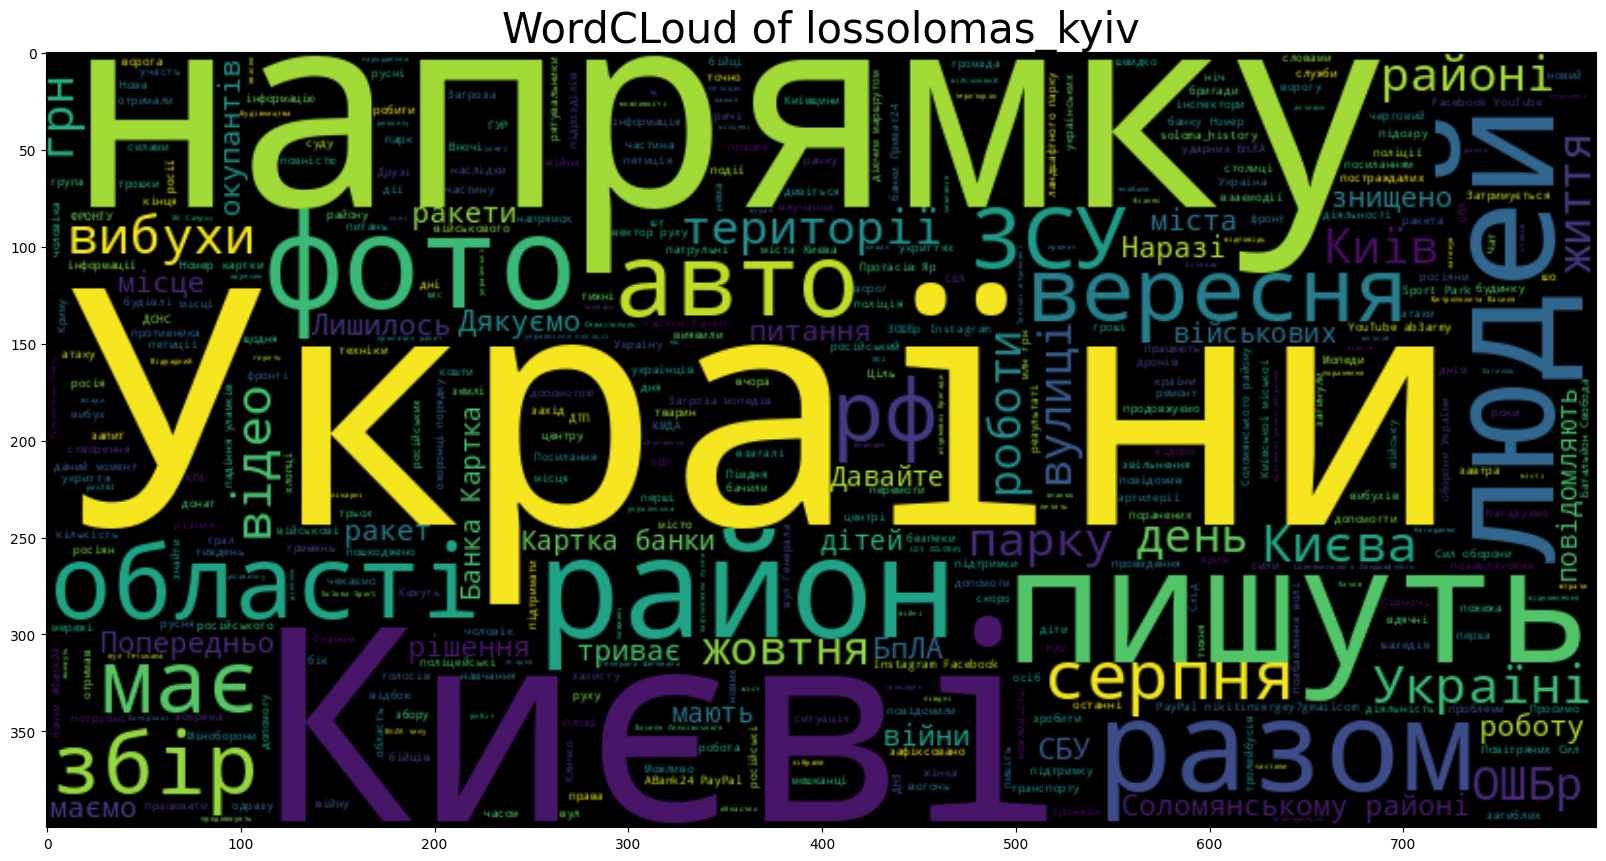

In [25]:
for df, df_name in zip([df_novynylive, df_lossolomas_kyiv], ['novynylive', 'lossolomas_kyiv']):
    plt.figure(figsize = (20,20)) 
    wc = WordCloud(
        max_words = 500, 
        width = 800, 
        height = 400, 
        stopwords = (ru_stopwords + ua_stopwords)).generate(" ".join(df["content_processed"]))
    plt.title(f"WordCLoud of {df_name}", fontsize=30)
    plt.imshow(wc, interpolation = 'bilinear')

# **Text embeddings**

In [26]:
sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", device=device,)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

In [27]:
# sent_embeddings_novynylive = sent_emb_model.encode(df_novynylive["content_processed"].to_list(), batch_size=100)
# sent_embeddings_lossolomas_kyiv = sent_emb_model.encode(df_lossolomas_kyiv["content_processed"].to_list(), batch_size=100)

In [28]:
# np.save(
#     "kyivchannels_sent_embeddings_novynylive.npy",
#     sent_embeddings_novynylive
# )


# np.save(
#     "kyivchannels_sent_embeddings_lossolomas_kyiv.npy",
#     sent_embeddings_lossolomas_kyiv
# )

In [29]:
sent_embeddings_novynylive = np.load(f"/kaggle/input/kyiv-channels-sentence-embeddings/kyivchannels_sent_embeddings_novynylive.npy")
assert sent_embeddings_novynylive.shape[0] == df_novynylive.shape[0]

sent_embeddings_lossolomas_kyiv = np.load(f"/kaggle/input/kyiv-channels-sentence-embeddings/kyivchannels_sent_embeddings_lossolomas_kyiv.npy")
assert sent_embeddings_lossolomas_kyiv.shape[0] == df_lossolomas_kyiv.shape[0]

# **Text Embeddings clustering**

# Pipeline
1. Take some Texts
2. Aplly TSNE and visualize
3. According to visualization - pick the number of Clusters for KMeans.
4. Examine KMeans clusters
5. Try to estimate the optimal distance threshold for DBSCAN from KMeans clusters
6. Examine DBSCAN clusters


In [30]:
index_without_duplicates_lossolomas_kyiv = df_lossolomas_kyiv.drop_duplicates("content_processed").index
random_ids_lossolomas_kyiv = random.sample(range(0, len(index_without_duplicates_lossolomas_kyiv)), 2784)

In [31]:
index_without_duplicates_novynylive = df_novynylive.drop_duplicates("content_processed").index
random_ids_novynylive = random.sample(range(0, len(index_without_duplicates_novynylive)), 3565)

In [32]:
df_novynylive["channelname"].iloc[random_ids_novynylive].value_counts()

channelname
novynylive    3565
Name: count, dtype: int64

In [33]:
df_lossolomas_kyiv["channelname"].iloc[random_ids_lossolomas_kyiv].value_counts()

channelname
lossolomas_kyiv    2784
Name: count, dtype: int64

In [34]:
def tsne_embed(sent_embed, random_ids):
    
    tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(sent_embed[random_ids])

    plt.title("TSNE novynylive embedding subset")
    plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
    plt.show()
    
    return tsne_news_embeddings_subset

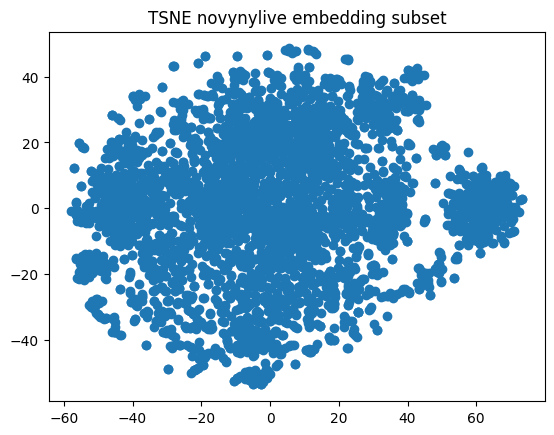

In [35]:
tsne_news_embeddings_subset_novynylive = tsne_embed(sent_embeddings_novynylive,random_ids_novynylive)

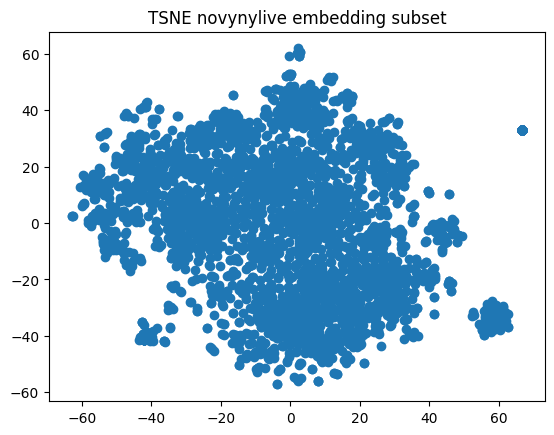

In [36]:
tsne_news_embeddings_subset_lossolomas_kyiv = tsne_embed(sent_embeddings_lossolomas_kyiv,random_ids_lossolomas_kyiv)

In [37]:
def KMeans_embed(embed_subset, df, indices):
    
    kmeans_clusts_news_embeddings_subset = KMeans(
        n_clusters=30, 
        random_state=42, 
        init="k-means++"
        ).fit_predict(embed_subset)

    plt.figure(figsize=(10,10))
    plt.title("TSNE news embedding subset + KMeans")
    for clust in np.unique(kmeans_clusts_news_embeddings_subset):
        plt.scatter(
            embed_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
            embed_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
            label=str(clust)
        )
        

    plt.legend()
    plt.show()
    
    print(df.iloc[indices][kmeans_clusts_news_embeddings_subset == 0].content.to_list()[:8])
    print()
    print()
    print(df.iloc[indices][kmeans_clusts_news_embeddings_subset == 17].content.to_list()[:8])
    print()
    print()
    print(df.iloc[indices][kmeans_clusts_news_embeddings_subset == 25].content.to_list()[:8])

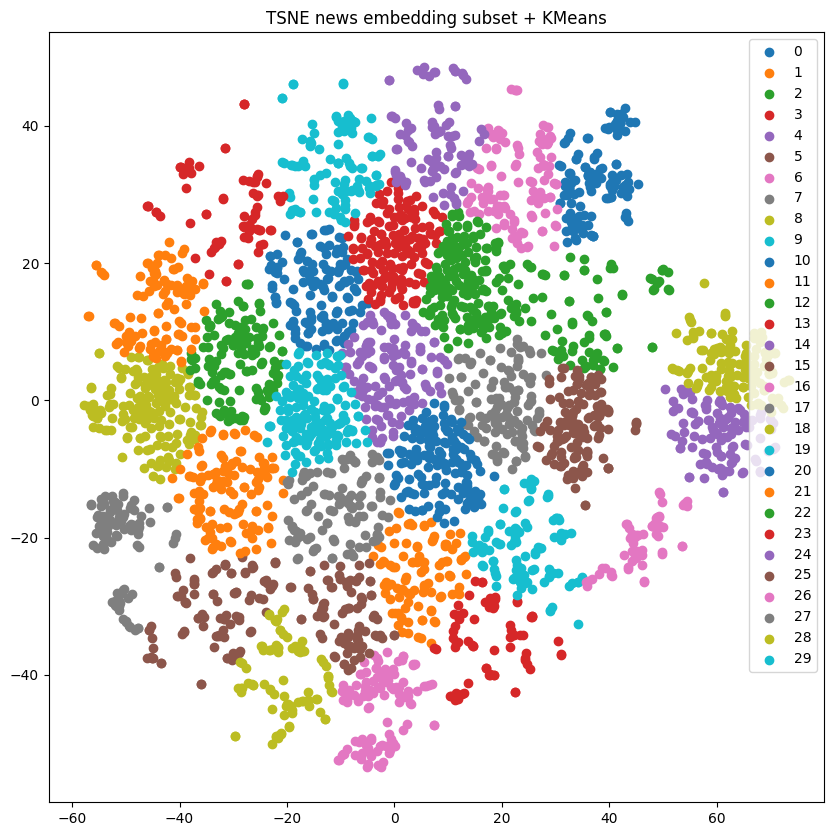

['На Кіровоградщині є влучання «шахедів», пошкоджена цивільна інфраструктура, — ОВА', 'Після 18 років перерви зі Львова до Варшави вирушив перший потяг\n\nПасажири їдуть з обласного центру у Раву-Руську, а там пересядуть у поїзд польського перевізника SKPL, який їде до Варшави.\n\nВідео: Максим Козицький\n\n🇺🇦 Новини.LIVE Львів', 'У тимчасово окупованому Луганську «місцева влада» нібито встановила пам‘ятник із датою закінчення війни Росії проти України\n\nНа постаменті зазначені дві дати — «2014» і «2023».', 'У бік Затока–Чорноморськ–Одеса', '15 років за ґратами отримав бойовик-садист, який виводив на «розстріл» мирних жителів Херсонщини\n\nКолишній житель Донеччини ще у 2014 році добровільно приєднався до окупантів. Разом з ними він воював проти Сил оборони і брав участь у захопленні лівобережної Херсонщини. Зловмисник знущався з людей та погрожував їм вбивством. Задокументовано факти, коли він прострілював ноги викраденим жителям області або стріляв поруч з головою потерпілих, імітую

In [38]:
KMeans_embed(tsne_news_embeddings_subset_novynylive, df_novynylive, random_ids_novynylive)

**First prompt**

The provided paragraphs cover several geopolitical developments, primarily related to Ukraine and Russia. Here is a brief summary:

S7 Airlines Flight Reduction:
The largest private airline in Russia, S7 Airlines, is set to reduce its flights by 10-15% due to issues with imported engines, particularly American P&W engines of the latest generation. Sanctions have caused difficulties in the planned maintenance of aircraft.

NATO Fleet in the Black Sea:
NATO countries are considering forming a fleet to clear the Black Sea grain corridor of mines. Turkey, Romania, and Bulgaria are discussing the creation of joint forces to neutralize drifting mines in their territorial waters, responding to the proximity of the Russian-Ukrainian war to their borders. This mission would be exclusively civilian, focusing on demining without additional NATO resources.

Accumulation of Rockets by Occupiers:
There are reports of occupiers accumulating rockets for attacks on critical infrastructure in Ukraine. The spokesperson for the Ukrainian Defense Intelligence Agency, Sergey Bratchuk, mentioned specific signs of such preparations, particularly in the Odessa region. Ukraine is strengthening its air defense systems in response.

Russian Military Presence in the Black Sea:
The Ukrainian Navy observes 13 enemy ships on combat duty in the Black Sea, including two carrying Kalibr cruise missiles. The report indicates a heightened military presence of the Russian forces in the region.

US Supply of ATACMS Rockets to Ukraine:
The United States has supplied ATACMS rockets to Ukraine after the Ukrainian counteroffensive did not meet expectations. The decision to provide these long-range missiles was influenced by both the slow progress of Ukrainian forces and the Russian buildup for an autumn offensive.

Reduction in Enemy Ships in the Black Sea:
The Ukrainian Navy initially reported 13 enemy ships in the Black Sea, but by midday, only seven remained. A submarine with four Kalibr missiles on board is still on combat duty.

Zelensky on Iran-Russia Missile Sale:
President Zelensky stated that there is no evidence of Iran buying missiles from Russia. Ukrainian services are in contact with partners to address this matter.

Security Initiatives for the Black Sea:
There are calls to liberate Crimea to ensure the safety of the Black Sea. Security initiatives previously hindered by Russia's stance are now being reconsidered, with a focus on the need for a unified position among interested countries, including NATO members, the USA, and the UK, to guarantee Black Sea security.

**Second prompt**

The provided paragraphs cover various topics in Ukraine, including the celebration of the Apple Savior holiday, the potential changes in utility tariffs in the 2024 state budget, Bulgaria's decision to stop importing Russian oil by October 2024, the impact of the Russian invasion on food prices in Ukraine, an analysis of the "Borscht Index," and developments related to the Ukrainian state budget for 2024. Additionally, there is information on the Ukrainian parliament's vote to increase expenditures in the 2023 state budget and President Zelensky's signing of a law to increase defense spending, allocating significant funds to the Ministry of Defense, the Ministry of Internal Affairs, and the Ministry of Social Policy.

**Third prompt**

The provided text includes several news articles from different regions of Ukraine. Here's a summary of each article:

Draft Dodging Operation in Odessa Region:

In the Bilhorod-Dnistrovskyi district, 18 individuals from various regions were apprehended for attempting to illegally leave the country to avoid military service.
They communicated with organizers online, who instructed them on actions and provided travel routes, demanding up to $5,000 for their services.
Administrative protocols were drawn up against the draft dodgers, who were sent to a local recruitment and social support center.
Confiscated Weapons in Odessa:

The State Bureau of Investigation handed over weapons confiscated from smugglers attempting to illegally sell machine guns in the Odessa region to the National Guard and Territorial Defense Forces.
The weapons had been illegally brought into Ukraine in 2014 and were valued at over 500,000 hryvnias.
Trafficking Victims Receive Status:

During the first nine months of the year, 86 Ukrainians were granted the status of trafficking victims.
The victims include 33 men, 38 women, 8 girls, and 7 boys.
The status allows them to receive free medical, psychological, social, legal, and other necessary assistance, along with one-time financial aid.
Lavish Wedding in Lviv:

A two-day lavish wedding celebration took place at the Emily Resort near Lviv, featuring performances by Ukrainian artists.
The bride and groom embraced Ukrainian traditions, with the bride wearing an embroidered dress on the second day.
Among the guests were notable businessmen, entrepreneurs, lawyers, and former law enforcement officers.
Spanish Police Seize Stolen "Scythian Gold":

Spanish police confiscated 11 jewelry items dating back to the Greek-Scythian period (8th to 4th century BCE), known as "Scythian gold," stolen from a Kyiv museum in 2016.
The criminals attempted to sell them in Madrid using forged documents claiming ownership by the Ukrainian Orthodox Church.
The items were part of a museum exhibit and had been illegally taken out of Ukraine.
Success in Returning Ukrainian Children:

The Ukrainian Parliament Commissioner for Human Rights, Dmytro Lubinets, stated that 99% of Ukrainian children returned from abroad were due to the efforts of the Ukrainian side alone.
Lubinets emphasized the need for continued information dissemination and legal actions against Russian officials involved in child abductions.
Corruption and Undeclared Assets in Rivne Region:

The head of the military enlistment office in the Rivne region is facing allegations of not declaring assets totaling 46 million hryvnias.
The official owns a house, a hotel under construction, a dacha, and several properties in different locations, along with three apartments and two garage spaces.
The investigation is ongoing.
Dismantling Illegal Migration Channel in Odessa:

Law enforcement in Odessa dismantled a channel involved in helping individuals illegally cross the border.
The criminals provided false documents allowing transit on the Odessa-Reni highway and then facilitated the individuals' journey to Moldova.
The organizers were apprehended, and funds, documents, and vehicles were seized. The pre-trial investigation is ongoing.

### We can see mixed topics in each paragraph, which means our algorithm is not working as well as we would like

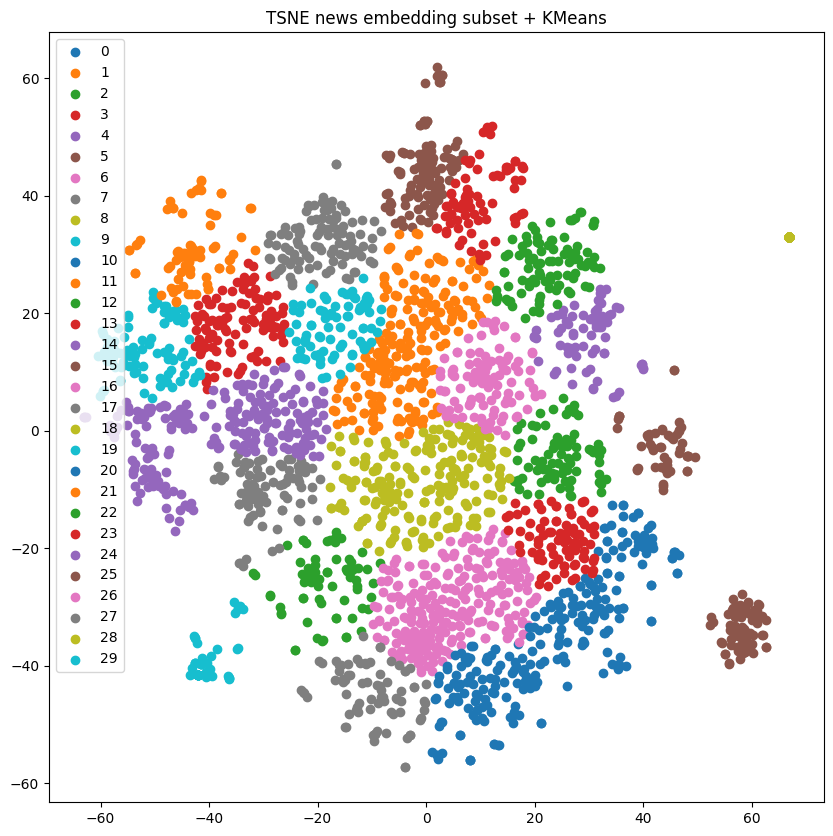

['Хто бажає підтримати нашу діяльність 👇\n\n5375411406638903 Моно \n\n4149629318828670 Приват24', 'Дякуємо за підтримку \U0001fae1\n\n5375411406638903 монобанк', 'Адмінам на каву:\n\n5375411406638903 Моно', 'Дякуємо \U0001fae1\n\nПідтримати наш канал:\n5375411406638903 Моно', 'Кидаємо генераторний клич!\n\nПоки ми готуємось до наступного великого непростого запиту , і займаємось поточним - є невеличка потреба для нашої 3 ОШБр😈\n\nХлопцям потрібно 6 інверторних генераторів на 3кВт\n\nЯкщо ви можете придбати / передати / подарувати - пишіть нам\n\nРобимо банку, аби хоч частково та оперативно закрити цю потребу бойовому піздрозділу!\nДолучайтесь\U0001fae1🇺🇦 (з банки на 100.000 ми можемо купити 4шт)\n\nБанка: https://send.monobank.ua/jar/8WNmBfKe8t\n\nКарта банки: 5375411208420005\n\nПриват24 : 4149 4993 9669 4489', 'Ранкову каву задонатьте на авто 👇\n\nЗБІР НА 2 АВТО ДЛЯ ФРОНТУ\n\n🔗Посилання на банку\nhttps://send.monobank.ua/jar/3WqZGemxQw\n\n💳Номер картки банки\n5375 4112 0798 1148\n\n4

In [39]:
KMeans_embed(tsne_news_embeddings_subset_lossolomas_kyiv, df_lossolomas_kyiv, random_ids_lossolomas_kyiv)

### We see that there is only one topic at first and second paragraphs, but there are a lot of different in third ones

# We can see mixed topics in some paragraphs, which means our algorithm is not working as well as we would like, it classifies several different topics as one, although it’s good that the algorithm identifies similar messages in some way. Let's try to use HDBSCAN, which may help avoid assigning two topics to one cluster

In [40]:
def hdbscan(embed_subset, df, indices):
    
    hdbscan = HDBSCAN(min_cluster_size=3).fit_predict(embed_subset)

    plt.figure(figsize=(10,10))
    plt.title("TSNE embedding subset + HDBSCAN")
    for clust in np.unique(hdbscan):
        plt.scatter(
            embed_subset[hdbscan == clust, 0],
            embed_subset[hdbscan == clust, 1],
            label=str(clust)
        )
    plt.legend()
    plt.show()
    
    print(df.iloc[indices][hdbscan == 1].content.to_list()[:8])
    print()
    print()
    print(df.iloc[indices][hdbscan == 17].content.to_list()[:8])
    print()
    print()
    print(df.iloc[indices][hdbscan == 25].content.to_list()[:8])

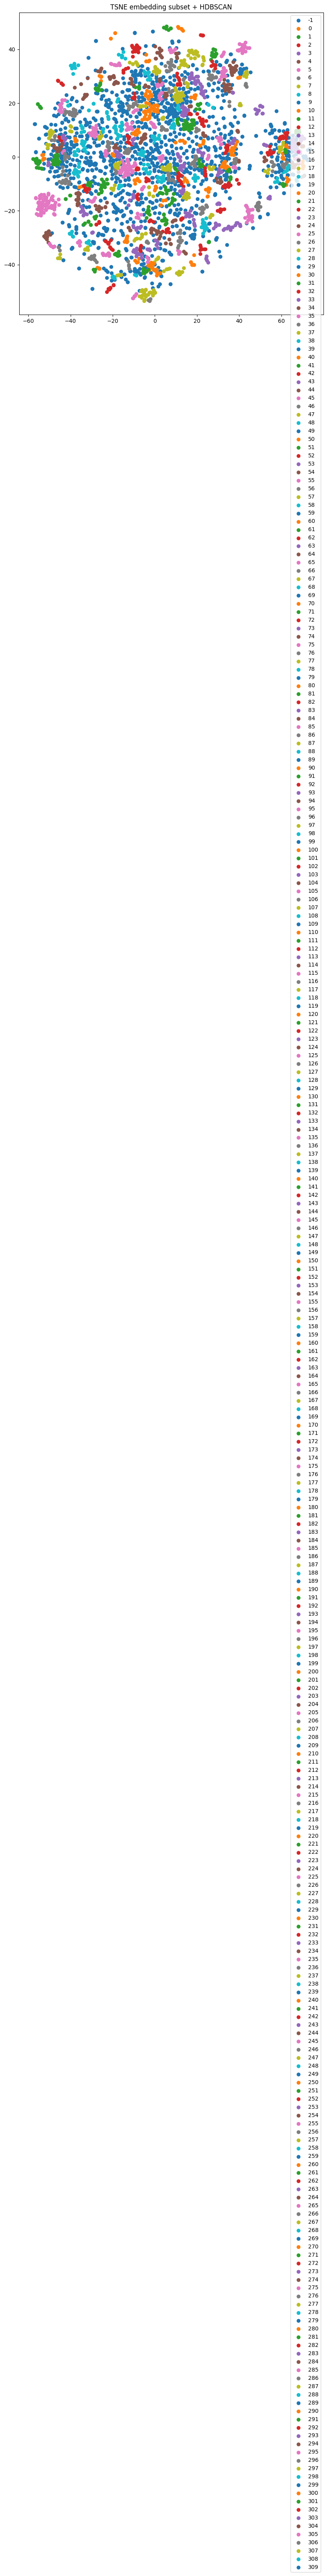

['Болгарія ввела податок на транзит російського «блакитного палива» в ЄС, — Bloomberg\n\nНовий законопроект передбачає плату в розмірі 20 болгарських левів ($10,76) за мегават-годину газу російського походження.\n\nДля власних потреб Болгарія не імпортує газ із Росії. Однак, територія країни є важливим маршрутом для трубопровідних потоків, які РФ відправляє в Європу.\n\nМайже половина російського «блакитного палива» надходить до Болгарії з Туреччини трубопроводом «Турецький потік».', "Плюс одна країна: Болгарія закриває кордон для авто з російською реєстрацією\n\n«До кінця дня Болгарія припинить в'їзд російських автомобілів на територію країни», — заявив начальник Прикордонної поліції країни Антон Златанов.\n\nЗМІ також повідомляють, що не пускатимуть російські авто Хорватія і Франція.", 'Влада Литви вимагає від власників машин з російськими номерами протягом півроку вивезти їх із країни, — митниця \n\nУ разі порушення — штраф або конфіскація автівки. Виняток — для росіян, які прямують

In [41]:
hdbscan(tsne_news_embeddings_subset_novynylive, df_novynylive, random_ids_novynylive)

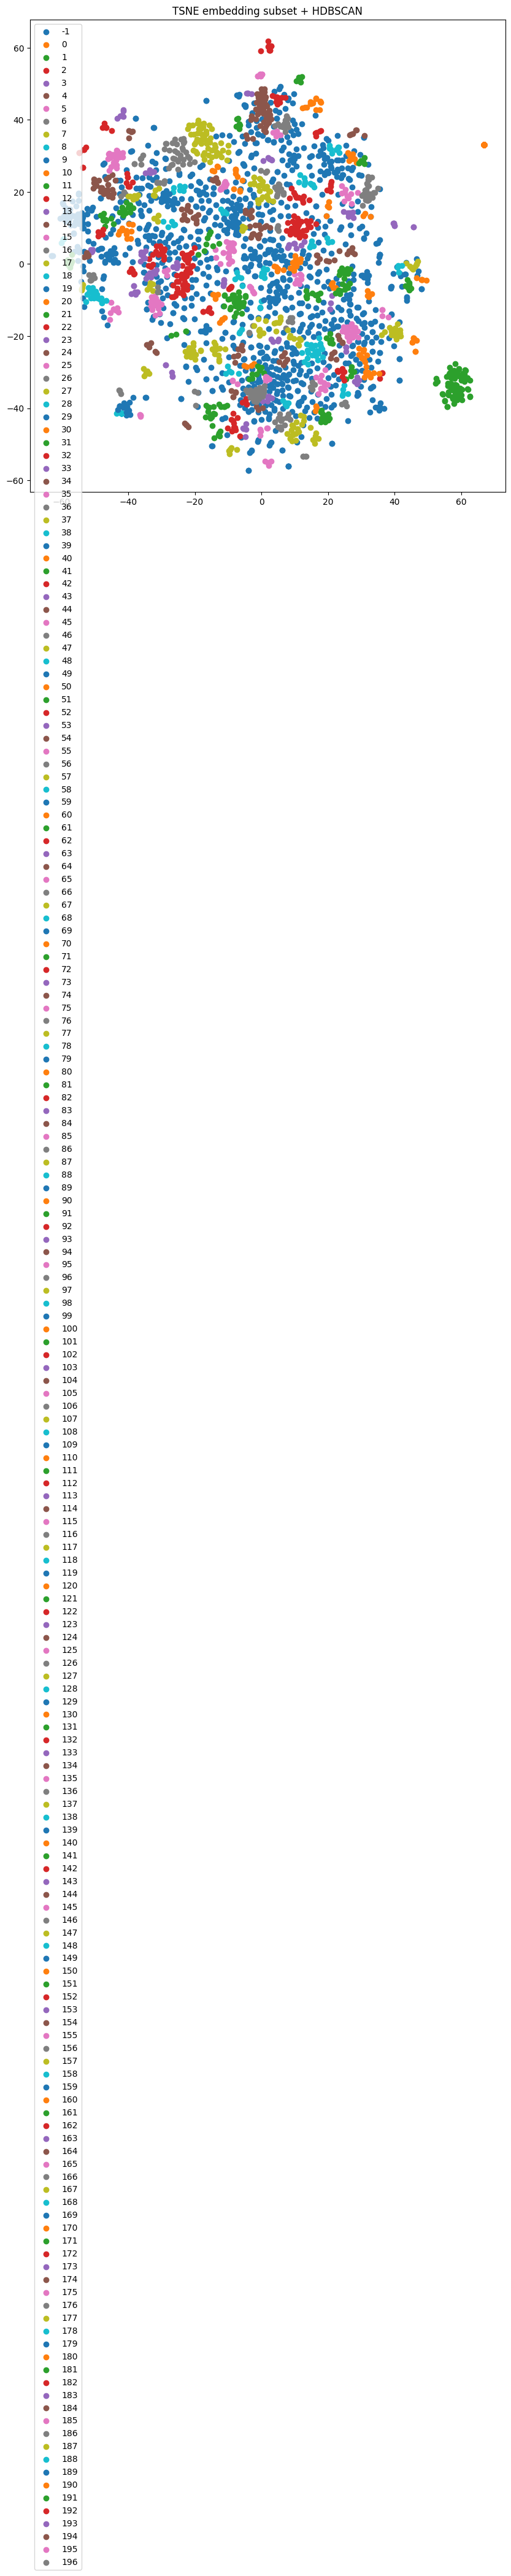

['-282.280', '-264.060', '-269.210', '-267.540', '-278.130', '-263.020', '-272.320', '-259.630']


['❤️Друзі, наша петиція №12544 набрала 6000 голосів!!!\n\nhttps://petition.kyivcity.gov.ua/petition/?pid=12544\n\nНагадаємо, що це вже друга наша петиція стосовно однієї і тієї ж локації - вул. Генарала Шаповала 1 - 3 та незаконного будівництва в підніжжі Солом\'янського Ландшафтного Парку.\n\nВ першій петиції, яка зараз активно в роботі КМР ми голосували за розірвання договору оренди земельної ділянки з забудовником ТОВ "Смарт - Девелопмент".\n\nВ другій петиції, ми голосували про передачу земельної ділянки парку, та створення на її місці зони спортивних майданчиків Soloma Sport Park🚴\u200d♀️.\nМи сформували бачення громади стосовно розвитку даної території. Те, що буде корисним для мешканців району, замість перспективи побачити черговий ЖК, який захоче звести будь який забудовник.\n\n⛹️Soloma Sport Park буде включати:\n- Футбольний майданчик\n- Баскетбольні зони\n- Тенісні корти та зона

In [42]:
hdbscan(tsne_news_embeddings_subset_lossolomas_kyiv, df_lossolomas_kyiv, random_ids_lossolomas_kyiv)

## Now we can admit that our alghoritm works much better, we only see distinct topics in eacth paragraph in both channels.

# **Topic Modelling**

In [43]:
from bertopic import BERTopic

# TODO: Try different models and hyperparameters. Link https://github.com/MaartenGr/BERTopic 

topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2", 
    verbose=True
)

In [44]:
topics, probs = topic_model.fit_transform(df_novynylive.iloc[random_ids_novynylive]['content_processed'].to_list())

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

2023-11-12 16:45:59,714 - BERTopic - Transformed documents to Embeddings
2023-11-12 16:46:38,299 - BERTopic - Reduced dimensionality
2023-11-12 16:46:38,483 - BERTopic - Clustered reduced embeddings


In [45]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0      -1   1075                                 -1_на_та_що_не   
1       0    263                   0_хамас_ізраїлю_ізраїль_гази   
2       1    203                          1_за_затримали_суд_до   
3       2    159                      2_повітряні_сили_viber_ми   
4       3    135               3_окупанти_обстріляли_по_росіяни   
..    ...    ...                                            ...   
62     61     11            61_стрілянину_вбив_відкрив_терорист   
63     62     11          62_добу_українські_окупантів_загальні   
64     63     11  63_харківської_авіаційних_окупанти_пошкоджено   
65     64     11                     64_isw_просунулися_наєв_км   
66     65     10             65_вибори_виборів_виборча_кампанія   

                                       Representation  \
0         [на, та, що, не, за, до, про, це, для, від]   
1   [хамас, ізраїлю, ізраїль, гази, газі, що, газа...   
2   [за, затримали, суд, до, років, підозру, та, н...   
3   [повітряні, сили, viber, ми, бпла, застосуванн...   
4   [окупанти, обстріляли, по, росіяни, ударів, до...   
..                                                ...   
62  [стрілянину, вбив, відкрив, терорист, анкарі, ...   
63  [добу, українські, окупантів, загальні, ліквід...   
64  [харківської, авіаційних, окупанти, пошкоджено...   
65  [isw, просунулися, наєв, км, сили, лівому, пів...   
66  [вибори, виборів, виборча, кампанія, чутки, чи...   

                                  Representative_Docs  
0   [Солдати РФ не могли такого зробити російська ...  
1   [ХАМАС не дозволяє евакуюватися мирним жителям...  
2   [На Одещині затримали чиновників які продавали...  
3   [Загроза ударних БпЛА для Запорізької області ...  
4   [580 снарядів за минулу добу окупанти випустил...  
..                                                ...  
62  [Стрілка з Брюсселя під ранок застрелили в каф...  
63  [За добу українські захисники знищили ще 800 о...  
64  [Окупанти пішли в атаку біля Зибиного на Харкі...  
65  [У Білорусі розпочався черговий етап перевірки...  
66  [Вибори під час війни чи справді влада готуєть...  

[67 rows x 5 columns]

In [46]:
topic_model.visualize_barchart()

In [47]:
topic_model.visualize_topics()

In [48]:
topics, probs = topic_model.fit_transform(df_lossolomas_kyiv.iloc[random_ids_lossolomas_kyiv]['content_processed'].to_list())

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm im

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

2023-11-12 16:50:48,269 - BERTopic - Transformed documents to Embeddings
2023-11-12 16:51:08,632 - BERTopic - Reduced dimensionality
2023-11-12 16:51:08,770 - BERTopic - Clustered reduced embeddings


In [49]:
topic_model.get_topic_info()

Topic  Count                                              Name  \
0      -1    969                                    -1_на_не_що_та   
1       0    128                                0_банки_нас_для_ми   
2       1     96                                             1____   
3       2     92                     2_київ_україни_країн_київщини   
4       3     80                                     3_ми_не_та_що   
5       4     55                           4_пишуть_нам_хтось_біля   
6       5     54                5_затримується_дтп_рух_тролейбусів   
7       6     51                     6_вибухи_вибух_місцеві_районі   
8       7     51                   7_youtube_3ошбр_instagram_бійці   
9       8     50                   8_ракет_ракета_ракети_балістики   
10      9     50                      9_бпла_зсу_бізнес_запорізька   
11     10     45                10_загиблих_поранених_кількість_по   
12     11     45                          11_парку_зона_park_sport   
13     12     43                   12_будьте_укриттях_летять_захід   
14     13     43                    13_246690_269760_247230_247850   
15     14     42                      14_міг_жесть_дорозвідка_жиза   
16     15     41                      15_вул_вас_максимальна_увага   
17     16     41              16_ракети_ракет_напрямку_повітряному   
18     17     35                   17_бортів_ту95_аеродрому_оленья   
19     18     34                                  18_063_98_808_93   
20     19     31                  19_парку_парк_будівництво_парків   
21     20     30                    20_пожежа_горить_пожежі_пожежу   
22     21     29                       21_вул_просп_далі_маршрутом   
23     22     28                         22_україні_f16_сша_abrams   
24     23     28                              23_підозру_сбу_за_та   
25     24     28                 24_росіяни_по_будинків_обстріляли   
26     25     26                   25_просмажка_русні_русня_курськ   
27     26     25                26_вибухи_вибух_окупована_феодосія   
28     27     25                                            27____   
29     28     25                    28_мі8_літак_літаки_російський   
30     29     24                              29_ми_не_ворогу_вами   
31     30     24              30_знищено_shahed136131_бпла_шахедів   
32     31     24                31_мопедів_загроза_півночі_мопєдів   
33     32     23  32_paypal_nikitinsergey7gmailcom_банки_посилання   
34     33     22                           33_сбу_атаки_дрони_дрон   
35     34     21                              34_днз_вулиці_на_кпі   
36     35     21       35_затримали_поліцейські_патрульні_чоловіка   
37     36     20                      36_спати_лягайте_спимо_спите   
38     37     19                  37_півдня_мопедів_загроза_зникли   
39     38     19                38_міст_кримський_кримському_мості   
40     39     19                            39_суд_суду_києва_суді   
41     40     18                            40_такоє_гуде_гойда_шо   
42     41     17                        41_загроза_сказу_котів_для   
43     42     17                                42_the_to_is_росія   
44     43     16                      43_поліція_поліції_відео_дрг   
45     44     15         44_аеропортах_аеропорт_аеропортів_внуково   
46     45     15                        45_будинок_будинку_маф_він   
47     46     14                   46_soloma_history_рік_1997_1979   
48     47     13                     47_мопеди_кривого_рогу_півдня   
49     48     13                      48_вечора_себе_elbarto_кухні   
50     49     12                    49_калібр_залп_ракет_загальний   
51     50     12                          50_грім_гучно_це_сміявсь   
52     51     12                                    51_ми_це_ти_що   
53     52     11                52_відбої_хлопець_арці_непрацюючій   
54     53     11                            53_млн_річки_робіт_грн   
55     54     11                                 54_31к_міг_раз_4й   
56     55     

In [50]:
topic_model.visualize_barchart()

In [51]:
topic_model.visualize_topics()

# Let's apply our pipeline for one more channel to see how it will perform on unprocessed data

In [52]:
df = pd.read_csv("/kaggle/input/kyivchannels/KyivChannels_Dataset_v01.csv", converters={"Date": pd.to_datetime})

In [53]:
df_obolonlife = df.loc[df['channelname'] == 'obolonlife'] 
df_obolonlife["content_processed"] = df_obolonlife["content"].apply(preprocess_text)

In [54]:
sent_embeddings_obolonlife = sent_emb_model.encode(df_obolonlife["content_processed"].to_list(), batch_size=100)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm im

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [55]:
# np.save(
#     "kyivchannels_sent_embeddings_obolonlife.npy",
#     sent_embeddings_obolonlife
# )

In [56]:
sent_embeddings_obolonlife = np.load(f"/kaggle/input/obolonlife/kyivchannels_sent_embeddings_obolonlife.npy")
assert sent_embeddings_obolonlife.shape[0] == df_obolonlife.shape[0]

In [57]:
index_without_duplicates_obolonlife = df_obolonlife.drop_duplicates("content_processed").index
random_ids_obolonlife = random.sample(range(0, len(index_without_duplicates_obolonlife)), 1060)

In [58]:
df_obolonlife["channelname"].iloc[random_ids_obolonlife].value_counts()

channelname
obolonlife    1060
Name: count, dtype: int64

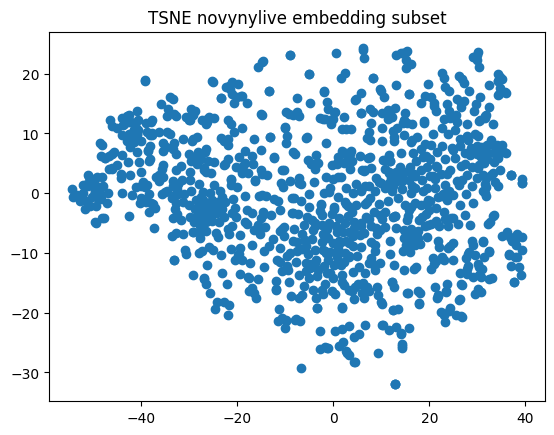

In [59]:
tsne_news_embeddings_subset_obolonlife = tsne_embed(sent_embeddings_obolonlife,random_ids_obolonlife)

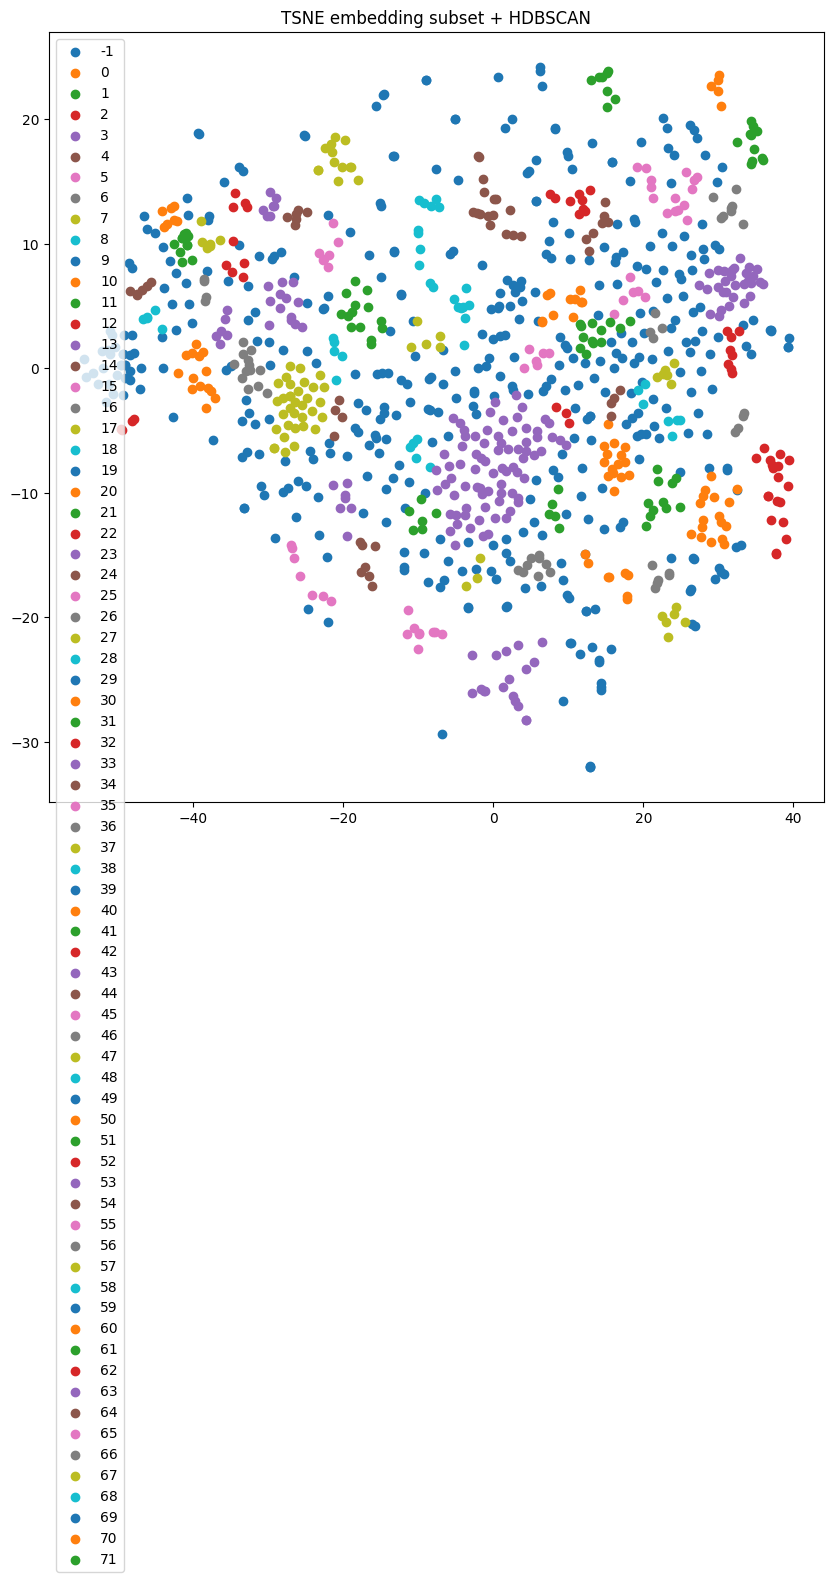

['Kyiv City Express на Електриків.\n\nЖиття\U0001faf6Оболонь', 'Вже 36 варшавських вагонів метро на Героїв Дніпра 🚇\n\nЖиття\U0001faf6Оболонь', '🚇Київметрополітен повідомив, що у серпні наша підземка отримала чергову партію варшавських вагонів – 12 одиниць рухомого складу. До кінця місяця планується транспортувати ще 6 вагонів.\n\nНаразі фахівці підприємства вивчають отримані раніше вагони. Попри те, що рухомий склад однієї серії, є багато розбіжностей, адже умови експлуатації поїздів у Варшавському та Київському метрополітенах суттєво відрізняються.\n\nЗагалом Варшавський метрополітен передає Київському метрополітену 60 вагонів серії №81, які виведені з експлуатації у варшавській підземці. Отриманий рухомий склад використовуватимуть у першу чергу як технічний донор. Також завдяки цим вагонам сформують резерв запчастин для подальших ремонтів діючих поїздів столичного метро.\n\nПоетапне транспортування рухомого складу розпочалось наприкінці квітня. Наразі підприємство отримало 30 вагоні

In [60]:
hdbscan(tsne_news_embeddings_subset_obolonlife, df_obolonlife, random_ids_obolonlife)

### We see that se have almost one topic at each paragrapth, what can be an indicator of goof result

In [61]:
topics, probs = topic_model.fit_transform(df_obolonlife.iloc[random_ids_obolonlife]['content_processed'].to_list())

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm im

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

2023-11-12 16:55:48,361 - BERTopic - Transformed documents to Embeddings
2023-11-12 16:55:54,699 - BERTopic - Reduced dimensionality
2023-11-12 16:55:54,750 - BERTopic - Clustered reduced embeddings


In [62]:
topic_model.get_topic_info()

Topic  Count                                      Name  \
0      -1    380                  -1_на_життяоболонь_не_до   
1       0     99                   0_життяоболонь_на_та_до   
2       1     54      1_районі_постраждалих_на_дарницькому   
3       2     49                        2_за_поліції_та_на   
4       3     47                            3_не_нам_на_це   
5       4     43      4_добраніч_вечора_життяоболонь_вечір   
6       5     37        5_доброго_ранку_ранок_життяоболонь   
7       6     33           6_життяоболонь_озеро_біле_озері   
8       7     31                      7_води_вода_не_порив   
9       8     30  8_оболонь_життяоболонь_ранкова_вереснева   
10      9     26           9_паркування_кмда_на_евакуатори   
11     10     25                 10_його_пишуть_не_чоловік   
12     11     20                   11_дтп_перехресті_на_та   
13     12     19                    12_україни_слава_ми_та   
14     13     19               13_бюджету_кмда_на_мільярди   
15     14     18              14_школи_шкіл_навчання_дітей   
16     15     17    15_масиву_мінського_життяоболонь_вечір   
17     16     16      16_небо_оболонське_неба_життяоболонь   
18     17     15         17_життяоболонь_героїв_трамвай_на   
19     18     15          18_вихідних_всім_гарних_чудового   
20     19     14                19_ділянки_земельної_та_на   
21     20     14              20_озера_набережної_жк_плесо   
22     21     13      21_дороги_великої_окружної_проспекту   
23     22     13        22_осінній_осінь_заморозки_оболоні   
24     23     13                23_вул_просп_рух_автобусів   

                                       Representation  \
0   [на, життяоболонь, не, до, та, що, це, за, вже...   
1   [життяоболонь, на, та, до, вул, оболонь, київ,...   
2   [районі, постраждалих, на, дарницькому, життяо...   
3   [за, поліції, та, на, що, під, до, управління,...   
4   [не, нам, на, це, по, вже, так, чи, івасюка, п...   
5   [добраніч, вечора, життяоболонь, вечір, ночі, ...   
6   [доброго, ранку, ранок, життяоболонь, добрий, ...   
7   [життяоболонь, озеро, біле, озері, озера, кири...   
8   [води, вода, не, порив, нам, вже, на, гарячої,...   
9   [оболонь, життяоболонь, ранкова, вереснева, гу...   
10  [паркування, кмда, на, евакуатори, та, не, авт...   
11  [його, пишуть, не, чоловік, він, на, що, пес, ...   
12  [дтп, перехресті, на, та, життяоболонь, біля, ...   
13  [україни, слава, ми, та, життя, посмертно, які...   
14  [бюджету, кмда, на, мільярди, зсу, не, під, ки...   
15  [школи, шкіл, навчання, дітей, та, на, для, уч...   
16  [масиву, мінського, життяоболонь, вечір, масив...   
17  [небо, оболонське, неба, життяоболонь, оболонь...   
18  [життяоболонь, героїв, трамвай, на, дніпра, пі...   
19  [вихідних, всім, гарних, чудового, оболоні, жи...   
20  [ділянки, земельної, та, на, оренди, площею, п...   
21  [озера, набережної, жк, плесо, біля, це, не, з...   
22  [дороги, великої, окружної, проспекту, богатир...   
23  [осінній, осінь, заморозки, оболоні, теплий, ж...   
24  [вул, просп, рух, автобусів, до, від, бандери,...   

                                  Representative_Docs  
0   [ПАРК НАТАЛКА ДЛЯ МАШИН І Кличко зі свитою біл...  
1   [ОболоньЗнайшла Продовжуємо нашу постійну рубр...  
2   [У Дарницькому районі рятувальники гасять поже...  
3   [Гучні справи проти олігархів чи варто чекати ...  
4   [Нам пишуть В районі метро Оболонь вночі стоїт...  
5   [Добраніч сусіди Тихої ночі ЖиттяОболонь, Добр...  
6   [Доброго ранку Оболонь ЖиттяОболонь, Доброго р...  
7   [Кирилівське озеро ЖиттяОболонь, Озеро Кирилів...  
8   [Нам пишуть Прошу допомогти в вирішенні пробле...  
9   [Ранкова Оболонь ЖиттяОболонь, Оболонь ранкова...  
10  [Нам пишуть Мешканці Оболонського району прося...  
11  [По ситуації на просп Івасюка пояснює свідок П...  
12  [Ми писали сьогодні про страшне ДТП на Гавансь...  
13  [Десятий рік російському злу і агресії протист...  
14  [Ініціював проведення сьогодні позачергового з...  
15  [КМВА ін

In [63]:
topic_model.visualize_barchart()

In [64]:
topic_model.visualize_topics()

# **Conclusions**
### **novynylive**
Ізраїль,
Обстріли,
Бійці
### **lossolomas_kyiv**
Збір коштів,
Вибухи,
Повітряні тривоги
### **oboloblive**
Постраждалі,
Повсякденне життя
